In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import skimage
from skimage.transform import resize
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import utils, callbacks
from tensorflow.keras import utils
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from keras.losses import CategoricalCrossentropy
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from sklearn import metrics

In [2]:
train_folder = 'C:/Users/subha/Downloads/ASL/asl_alphabet_train/asl_alphabet_train'
all_data = []
for folder in os.listdir(train_folder):
    
    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    #print(onlyfiles)
    all_data += onlyfiles
data_df = pd.DataFrame(all_data)
data_df

,label,path
0,A,C:/Users/subha/Downloads/ASL/asl_alphabet_trai...
1,A,C:/Users/subha/Downloads/ASL/asl_alphabet_trai...
2,A,C:/Users/subha/Downloads/ASL/asl_alphabet_trai...
3,A,C:/Users/subha/Downloads/ASL/asl_alphabet_trai...
4,A,C:/Users/subha/Downloads/ASL/asl_alphabet_trai...
...,...,...
86995,Z,C:/Users/subha/Downloads/ASL/asl_alphabet_trai...
86996,Z,C:/Users/subha/Downloads/ASL/asl_alphabet_trai...
86997,Z,C:/Users/subha/Downloads/ASL/asl_alphabet_trai...
86998,Z,C:/Users/subha/Downloads/ASL/asl_alphabet_trai...


In [3]:
x_train,x_holdout = train_test_split(data_df, test_size= 0.10, random_state=42,stratify=data_df[['label']])
x_train,x_test = train_test_split(x_train, test_size= 0.20, random_state=42,stratify=x_train[['label']])

In [4]:
img_width, img_height = 64, 64
batch_size = 128
y_col = 'label'
x_col = 'path'
no_of_classes = len(data_df[y_col].unique())


train_datagen = ImageDataGenerator(rescale = 1/255.0)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=x_train,x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height),class_mode='categorical', batch_size=batch_size,
    shuffle=False,
)

validation_datagen = ImageDataGenerator(rescale = 1/255.0)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=x_test, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

holdout_datagen = ImageDataGenerator(rescale = 1/255.0)
holdout_generator = holdout_datagen.flow_from_dataframe(
    dataframe=x_holdout, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

Found 62640 validated image filenames belonging to 29 classes.
Found 15660 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


In [5]:
base_model = VGG16(weights = "imagenet", include_top = False, input_shape = (64, 64, 3))
base_model.trainable = False ## Not trainable weights

58900480/58889256 [==============================] - 4s 0us/step


In [6]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [7]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, activation='relu')
dropout_layer_1 = layers.Dropout(0.5)
#dense_layer_2 = layers.Dense(512, activation='relu')
#dropout_layer_2 = layers.Dropout(0.5)
prediction_layer = layers.Dense(29, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer_1,
    #dense_layer_2,
    #dropout_layer_2,
    prediction_layer
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 29)                14877     
Total params: 15,778,653
Trainable params: 1,063,965
Non-trainable params: 14,714,688
_________________________________________________________________


In [9]:
classes = 29
epochs = 10
learning_rate = 0.0001

adam = Adam(lr=learning_rate)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_generator, shuffle=True)

Epoch 1/10


C:\Users\subha\anaconda3\envs\tf-gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


490/490 [==============================] - 64s 121ms/step - loss: 2.1076 - accuracy: 0.4628 - val_loss: 1.1450 - val_accuracy: 0.8003
Epoch 2/10
490/490 [==============================] - 47s 96ms/step - loss: 0.9852 - accuracy: 0.7592 - val_loss: 0.6410 - val_accuracy: 0.8882
Epoch 3/10
490/490 [==============================] - 47s 97ms/step - loss: 0.6439 - accuracy: 0.8461 - val_loss: 0.4370 - val_accuracy: 0.9275
Epoch 4/10
490/490 [==============================] - 48s 98ms/step - loss: 0.4732 - accuracy: 0.8871 - val_loss: 0.3250 - val_accuracy: 0.9476
Epoch 5/10
490/490 [==============================] - 49s 101ms/step - loss: 0.3625 - accuracy: 0.9175 - val_loss: 0.2486 - val_accuracy: 0.9592
Epoch 6/10
490/490 [==============================] - 52s 106ms/step - loss: 0.2914 - accuracy: 0.9350 - val_loss: 0.2006 - val_accuracy: 0.9667
Epoch 7/10
490/490 [==============================] - 50s 103ms/step - loss: 0.2388 - accuracy: 0.9477 - val_loss: 0.1641 - val_accuracy: 0.9741

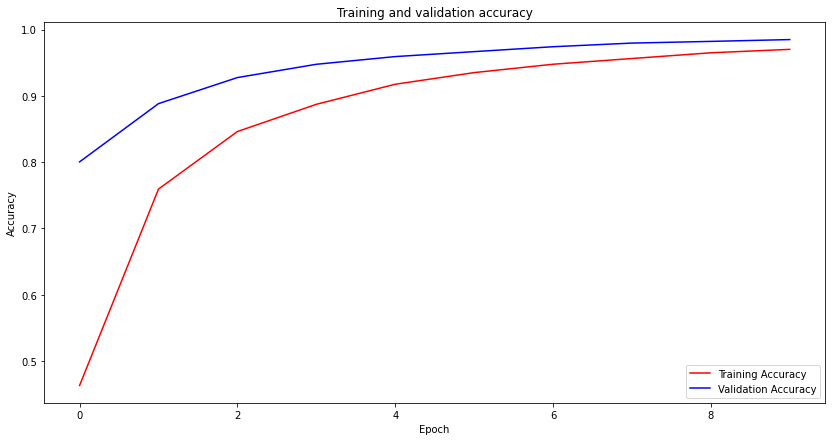

In [10]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

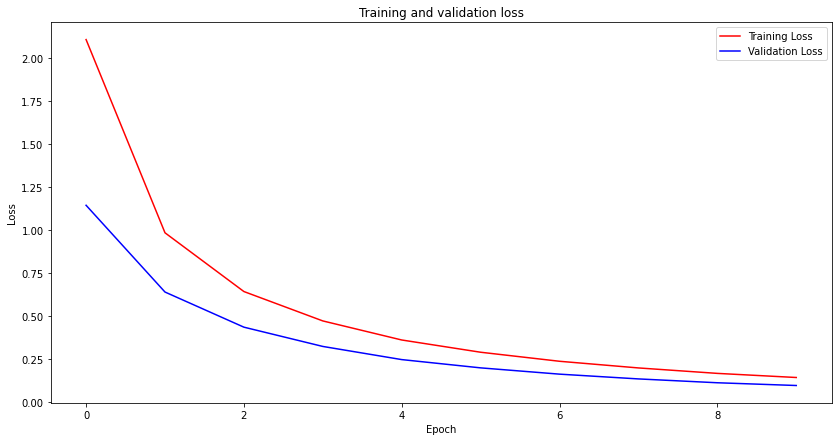

In [11]:

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [12]:
predictions = model.predict(holdout_generator, verbose=1)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1) #multiple categories

true_classes = holdout_generator.classes
class_labels = list(holdout_generator.class_indices.keys())  
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

68/68 [==============================] - 9s 127ms/step
              precision    recall  f1-score   support

           A       0.99      0.99      0.99       300
           B       0.98      1.00      0.99       300
           C       1.00      1.00      1.00       300
           D       1.00      1.00      1.00       300
           E       0.97      0.96      0.97       300
           F       1.00      0.99      1.00       300
           G       0.99      0.99      0.99       300
           H       0.99      0.99      0.99       300
           I       0.99      0.97      0.98       300
           J       0.99      1.00      1.00       300
           K       0.99      0.99      0.99       300
           L       0.99      1.00      1.00       300
           M       0.98      0.98      0.98       300
           N       0.98      0.97      0.98       300
           O       1.00      0.99      0.99       300
           P       0.97      1.00      0.99       300
           Q       1.00   

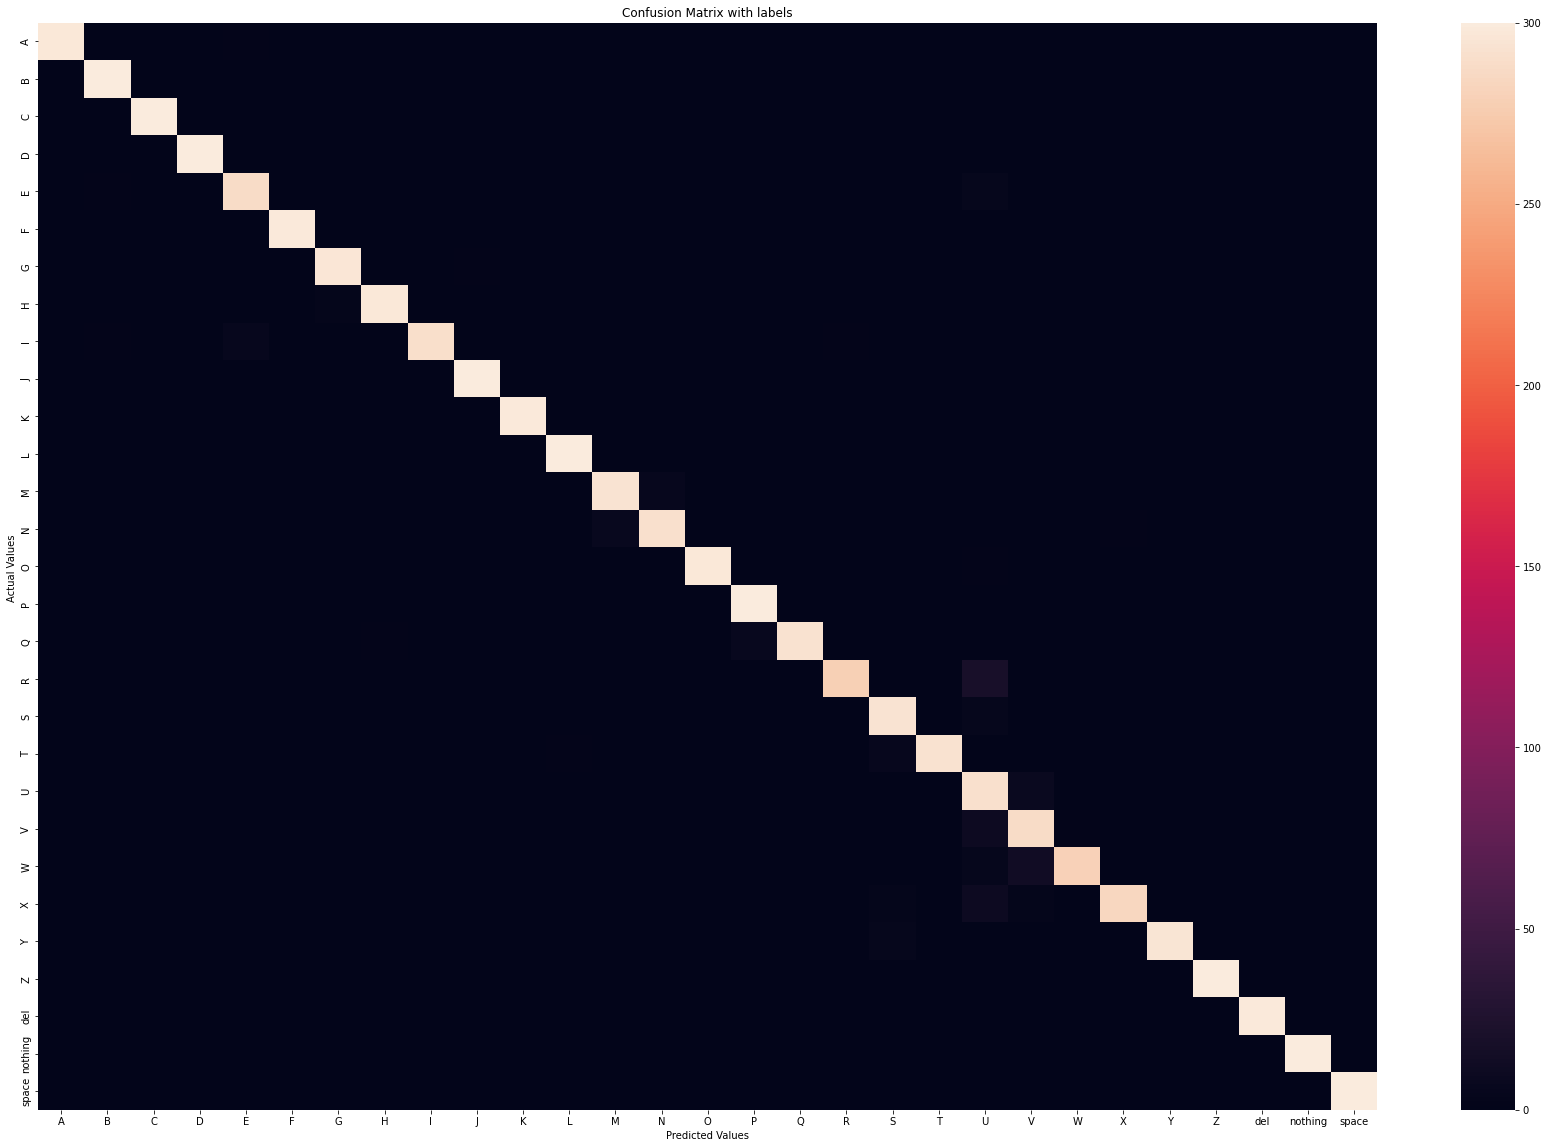

In [13]:
plt.figure(figsize=(30, 20))

ax = sns.heatmap(metrics.confusion_matrix(true_classes,predicted_classes))
ax.set_title('Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

plt.show()

In [14]:
model.save('VGG16.h5')

In [15]:
confusion = metrics.confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[297   0   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   1   0   0   0   0   0]
 [  0 299   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   1   0   0   0   0   0   0   0]
 [  0   0 300   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 300   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  1   2   0   0 288   0   0   0   1   0   0   0   0   0   0   0   0   0
    1   1   4   1   0   1   0   0   0   0   0]
 [  0   0   0   0   1 298   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 296   1   0   2   0   0   0   0   0   1   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   3 297   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   2   0 

<AxesSubplot:>

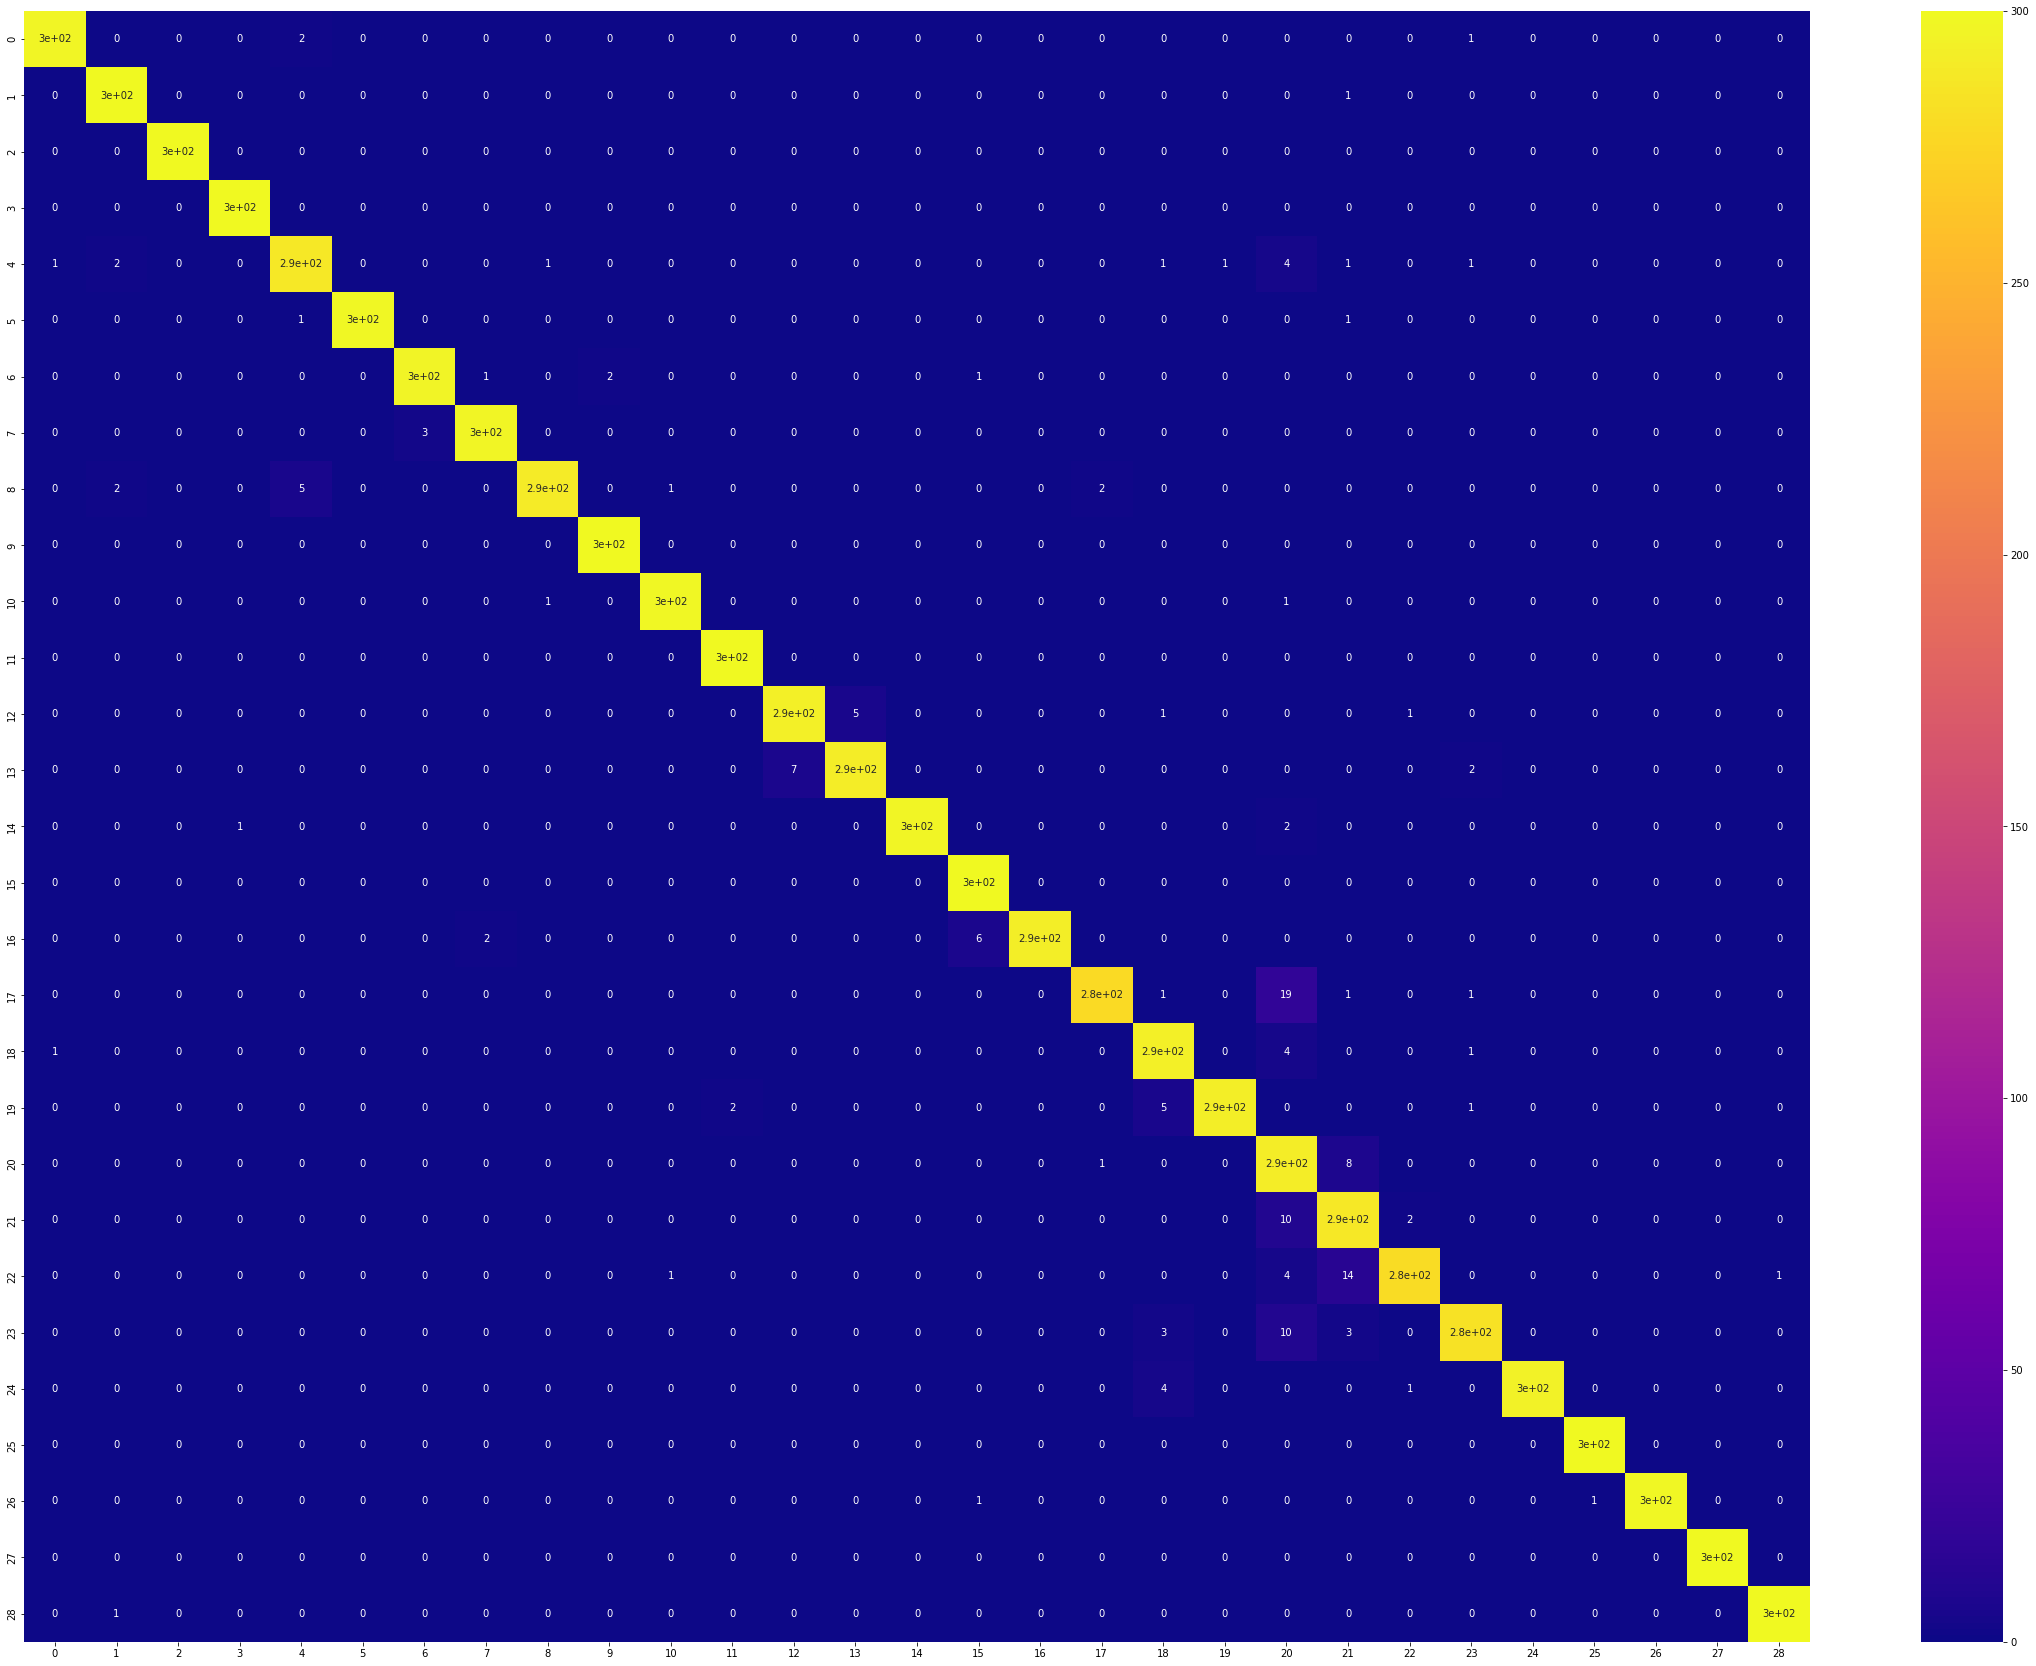

In [16]:
plt.figure(figsize=(40, 30))
sns.heatmap(confusion, cmap="plasma", annot=True)